# Python and NetCDF climate data
Unlike MatLab, Python does not have native support for multidimensional NetCDF datasets. Instead, we have to import a few specific packages into our script and do a few extra steps to manipulate the data. The notebook below demonstrates the steps needed to import, link variables representing the different dimensions, and run simple analyses on netCDF data.  

In the example here, we'll use daily precipitation predictions downscaled to a 1/16-degree resolution spanning the years 1990 to 2005. Thus, our data has 4 dimensions: `latitude`, `longitude`, `time`, and `precipitation`. *(Actually, the dataset has a 5th "dimension" as well, but this only includes data on the geographic coordinate reference system and has only one value, so we'll ignore it)*. 

Resources: 
* http://www.ceda.ac.uk/static/media/uploads/ncas-reading-2015/10_read_netcdf_python.pdf

## 1. Import the `.nc` data file into our Python script as netCDF4 `dataset` object
The Python *NetCDF4* package allows us to read in our `.nc` file into a NetCDF4 `dataset` object that we can manipulate programmatically. Documentation on the NetCDF4 package is here: http://unidata.github.io/netcdf4-python/, and it displays the various *properties* and *methods* of the `dataset` object. 

In [2]:
#Import package to read netCDF file
import netCDF4

In [ ]:
#Read the file into a netCDF dataset object
fileName = 'macav2livneh_pr_bcc-csm1-1_r1i1p1_historical_1990_2005_CONUS_monthly.nc'
dataset = netCDF4.Dataset(fileName)

In [3]:
#Confirm that the `dataset` variable points to a netCDF4 dataset object
type(dataset)

netCDF4._netCDF4.Dataset

In [4]:
#Show some documentation on the `dataset` object
?dataset

In [5]:
dataset.file_format

'NETCDF4'

## 2. Explore out netCDF dataset
With our dataset object created, we can explore a bit about the data within it and its structure. Specifically, we'll examine what <u>dimensions</u>, <u>variables</u>, and <u>attributes</u> are contained within the dataset

### 2.1 Dimensions
The dimensions in our dataset are accessed as a Python **dictionary**, which is a collection of values referenced by specific keys. Here, each dimension is listed as a *key*, and to get information about that dimension, we "look up" its definition in the dictionary: 

In [8]:
#Show the full dimensions dictionary
dataset.dimensions

OrderedDict([('lat',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 444),
             ('lon',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 922),
             ('time',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 192),
             ('crs',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'crs', size = 1)])

In [9]:
#Show just the keys, or dimensions, in the dataset
dataset.dimensions.keys()

odict_keys(['lat', 'lon', 'time', 'crs'])

In [10]:
#Show the values associated with the `time` dimension
dataset.dimensions['time']

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 192

► *<u>Now you try it</u>: Show the values associated with the "lat" dimension. How many items are in this dimension? How many in the 'lon' and 'crs' dimensions?*

In [12]:
dataset.dimensions[]

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 444

Summing up, we see our dataset has 4 dimensions: 
* `lat` with 444 values
* `lon` with 922 values
* `time` with 192 values, and 
* a coordinate reference system (`crs`) with one value

### 2.2 Variables
Like dimensions, the dataset's variables are accessed as dictionary objects. First let's list all the variables contained in our datset by exposing the "keys" included in the dictionary. 
Our dataset has 5 variables:

In [13]:
#Show the 'key' or names of the variables
dataset.variables.keys()

odict_keys(['lat', 'lon', 'time', 'precipitation', 'crs'])

We see many of the same names as the dimensions, but also a *precipitation* variable. 
* `lat`
* `lon`
* `time`
* `precipitation`
* `crs`

In [14]:
#Show attributes of the precipitation variable
dataset.variables['precipitation']

<class 'netCDF4._netCDF4.Variable'>
float32 precipitation(time, lat, lon)
    _FillValue: -9999.0
    long_name: Monthly Precipitation Amount
    units: mm
    grid_mapping: crs
    standard_name: precipitation
    cell_methods: time: sum(interval: 24 hours): sum over days
    coordinates: time lon lat
    comments: Total monthly precipitation at surface: includes both liquid and solid phases from all types of clouds (both large-scale and convective)
unlimited dimensions: 
current shape = (192, 444, 922)
filling on

### 2.3 Attributes
NetCDF datasets have both global attributes and attributes associated with each variable. Here's how we explore what attributes are included in each and how to access information on each attribute

#### 2.3.1 Global attributes
Listing the datset's **global** attributes is done bit differently than the process for dimensions and variables. Here, the `ncattrs()` function returns a list of the dataset's global attributes. Then we can display more information on any of these attributes using the `getattr()` function. 

In [ ]:
#List the dataset's attributes
dataset.ncattrs()

In [40]:
#Display information stored in the `summary` attribute
dataset.summary

'This archive contains downscaled meteorological and hydrological projections for the Conterminous United States at 1/16-deg resolution utilizing the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou, 2012) statistical downscaling method with the Livneh et al (2013) training dataset. The downscaled meteorological variables are maximum/minimum temperature(tasmax/tasmin), precipitation amount(pr), downward shortwave solar radiation(rsds), wind speed(was), and specific humidity(huss). The downscaling is based on the 365-day model outputs from different global climate models (GCMs) from Phase 5 of the Coupled Model Inter-comparison Project (CMIP3) utlizing the historical (1950-2005) and future RCP4.5/8.5(2006-2099) scenarios. Leap days have been added to the dataset from the average values between Feb 28 and Mar 1 in order to aid modellers.'

#### 2.3.2 Variable attributes
Now we'll focus on the attributes of a single variable in our datatset. We'll choose the `precipitation` variable. 

In [43]:
#List the precipitation variable's attributes
dataset.variables['precipitation'].ncattrs()

['_FillValue',
 'long_name',
 'units',
 'grid_mapping',
 'standard_name',
 'cell_methods',
 'coordinates',
 'comments']

In [48]:
#Reveal the information associated with the "cell_methods" attribute
dataset.variables['precipitation'].cell_methods

'time: sum(interval: 24 hours): sum over days'

*There's a lot going on in the above statements. It works, but it can be hard to read for the newbie. One of the advantanges of Python code is its readability, but this only works of coders write the code to be readable. So, let's rewrite the above statement so that it's more readable. It appears less "efficient", but sometimes readability is better than terseness.*

In [45]:
#Pull the precipitation variable into a Python variable called "precip"
precip = dataset.variables['precipitation']
#Now list its attributes
precip.ncattrs()

['_FillValue',
 'long_name',
 'units',
 'grid_mapping',
 'standard_name',
 'cell_methods',
 'coordinates',
 'comments']

With the `precip` Python variable established, we can use it to display attribute contents directly

In [50]:
precip._FillValue

-9999.0

---
## 3. Working with the data
With some familiarity of what's in the dataset, we can now start manipulating and visualizing the data...

### 3.1 Import the variables into netCDF4 `variable` objects
Let's now break our dataset into its component variables so that we can work with each more easily. Here, we assign Python variables to the four dataset variables: `time`, `latitute`, `longitude`, and `precipitation`. (We'll ignore the `crs` variable as that contains only one value, a metadata value listing the coordinate system used.) Then, we'll quickly examine some properties of these variable objects. 

In [31]:
#Read the variables in NETCDF file
time = dataset.variables['time']
lon = dataset.variables['lon']
lat = dataset.variables['lat']
precip = dataset.variables['precipitation']

In [32]:
#Confirm that these objects are netCDF4 variables
type(precip)

netCDF4._netCDF4.Variable

In [33]:
#Display what we can do with a variable object
?precip

In [63]:
#What if we just display everything about the variable?
precip

<class 'netCDF4._netCDF4.Variable'>
float32 precipitation(time, lat, lon)
    _FillValue: -9999.0
    long_name: Monthly Precipitation Amount
    units: mm
    grid_mapping: crs
    standard_name: precipitation
    cell_methods: time: sum(interval: 24 hours): sum over days
    coordinates: time lon lat
    comments: Total monthly precipitation at surface: includes both liquid and solid phases from all types of clouds (both large-scale and convective)
unlimited dimensions: 
current shape = (192, 444, 922)
filling on

► *<u>Now you try it</u>: Recalling how we revealed the attributes of the `precip` variable above, what are the units of the `time` variable? The `lat` and `lon` variables?*

In [60]:
time.units, lat.units, lon.units

('days since 1900-01-01 00:00:00', 'degrees_north', 'degrees_east')

**Variable shape**: These four variables are all <u>arrays</u>, i.e. a series of values set across one or or more dimensions. We can examine the size and dimensions of each variable via its `shape` property:

In [67]:
time.shape

(192,)

In [64]:
lat.shape

(444,)

In [66]:
lon.shape

(922,)

In [68]:
precip.shape

(192, 444, 922)

**Note** that the size of the three dimensions of the `precip` variable corresponds to the size of the `time`, `lat`, and `lon` variables, respectively. <u>*This gives a more tangible sense of how these data are structured and how we can manipulate our data.*</u>

More specifically, we see that the data in the `precip` variable is 3 dimensional. The first dimension is time, and the other two dimensions are x-y coordinates in space. So we can <u>envision our data as a stack of precipitation maps, with each layer in the stack as precipitation values for a single time snapshot.</u> This helps us in subsetting our data...

What may not be clear here is: *what then are the `time`, `lat`, and `lon` variables, if everything is held in the one `precip` variable?* This has everything to do with the fact that the actual data (i.e., the amount of precipitation) are referenced by their *index position* in the array, as we'll see in a moment. It'd be confusing to explain this in more detail at the moment. Instead, let's move a bit further with the data and then we'll come back to this. 


---
### 3.2 Extracting data from our variables

#### 3.2.1 Extract a single value (i.e. single location-time value)
The `precip` variable has 3 axes: `time`,`lat`, and `lon`, with sizes of 192, 444, and 922, respectively. And the value at a given time/geographic coordinate is the predicted rainfall at that specific time/location. We can extract a specific precipitation value by specifying a `time`, `lat`, and `lon` value:

In [69]:
print(precip[0,250,300])

37.11904


The interpolated precipitation at that time/location is `37 mm`. 

<u>But what time and location did we actually specify??</u> *What is time=0?? Likewise, a latitude of "250" and a longitude of "300" are not really geographic coordinates.* 

These values are actually pointers to the **positions** in the precipitation array, that is, the 1st time slice, the 251st "latitude" column, and the 301st "longitude" column - if you think of our precipitation array as a stack of lat/long tables, with a layer for each time. (Also note that Python indices are zero-based, meaning the values start at zero, not 1.)

**So how, then, do we extract data for a known time and/or location?** Well, those data are contained in the other arrays, with positions corresponding to the axes in the precipitation array:

In [70]:
print(time[0])
print(lat[250])
print(lon[300])

32864.0
40.78125
254.15625


So, we see that the precipitation value extracted above is associated with the location (`40.71824°N`,`254.15625°W`) and the time "`32864`"??!?

That time value is actually days since 01-01-1990 (found in the datasets metadata):

In [ ]:
time.units

And we have tools to conver this into a more readable format:

In [71]:
#Create a new array, converting days since 1900 to a date time value
time2 = netCDF4.num2date(time[:],time.units)
time2[0]

datetime.datetime(1989, 12, 24, 0, 0)

And we see the first time slice is Dec 12, 1989. 

So now what we have to do is somehow cross-reference the *values* in the `time2`, `lat`, and `lon` arrays with the *axes* in the precipitation array. In doing so, we can more easily extract values we want and run various analyses on the data. 

## 4. Python's NumPy (numeric Python) package

### 4.1 Converting the netCDF4 variable into NumPy arrays
The process to do this involves converting each of our NetCDF variabls into numeric arrays which then allows us to use Python's **NumPy** package to do exactly what we need to do...

In [81]:
#Import the numpy package, calling it "np" to save typing
import numpy as np

In [82]:
#Convert the NetCDF variables to numpy arrays 
arrPrecip = precip[:]
arrLat = lat[:]
arrLon = lon[:]
arrTime = time2[:].astype(np.datetime64)

In [83]:
#Show the type of object created
type(arrPrecip)

numpy.ma.core.MaskedArray

The netCDF variables were converted to Numpy *masked arrays*. This means that, in addition to the N-dimensional numeric array, we have an associated n-dimensional array, but one with boolean values that indicate whether the data should be used in calculations or not.  

In [84]:
#Show the shape of the precip array
precip.shape

(192, 444, 922)

Numpy arrays work much like the netCDF variables in terms of querying values using their position...

In [86]:
arrPrecip[0,250,300]

37.11904

In [90]:
arrTime[0]

numpy.datetime64('1989-12-24T00:00:00.000000')

In [91]:
arrLat[250]

40.78125

In [92]:
arrLon[300]

254.15625

### 4.2 Subsetting our data
With our variable stored as NumPy arrays, we can use NumPy methods to slice our data across time and/or space. We'll begin simply by just [blindly] using raw position values (i.e. not actual times or lat/long coordinates) to do first a time series plot and then a simple map for a single time slice. 

#### 4.2.1 Time series for one location
To extract precipitation across all time for one location (here we'll choose the `lat` at position `250` and the lon at postition `300`), we use a colon to say "grab all values" at the first axis (`time`), then then specific values for the `lat` and `lon` axes. 

In [147]:
#Grab all the precip data at location lat200 and lon300
precip_timeseries = arrPrecip[:,250,300]

In [148]:
#What is the shape of the result: should be 192 
precip_timeseries.shape

(192,)

In [149]:
#Show the first 10 values in the resulting array
precip_timeseries[0:10].data

array([ 37.11904 ,  64.036575,  45.392483, 122.75209 , 121.195694,
        19.678436,  25.675114,  75.88427 ,  42.54946 ,  56.04633 ],
      dtype=float32)

#### Plotting - with NumPy & <u>MatPlotLib</u>
We use another library for plotting. Python has a few, but as you are likely familiar with Matlab, we'll use `matplotlib` which was desinged after Matlab's plotting procedures. 

In [150]:
#Import the pyplot subpackage and enable inline plotting
from matplotlib import pyplot as plt
%matplotlib inline

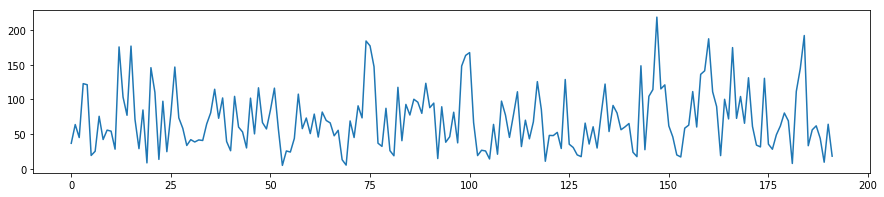

In [152]:
#Plot as a time series
fig = plt.figure(figsize=(15,3))
plt.plot(precip_timeseries);

#### Plotting - with MatPlotLib & <u>Pandas</u> 
The above plot shows the time series, but the axes are still just row positions, not actual time. NumPy is greate for manipulating data stored in n-dimensional arrays, but it has limitations. Moving our data from a NumPy array into a **Pandas DataFrame** offers more functionality, including the ability to move our `arrTime` array as the index of our time series data. Doing so allows us to use actual times as our X-axis ticks.

In [135]:
#Import Pandas
import pandas as pd

In [155]:
#Convert our NumPy Array to a Pandas dataframe
df_timeseries=pd.DataFrame(precip_timeseries)

In [156]:
#Set the index of the time series to be 
df_timeseries.index=arrTime

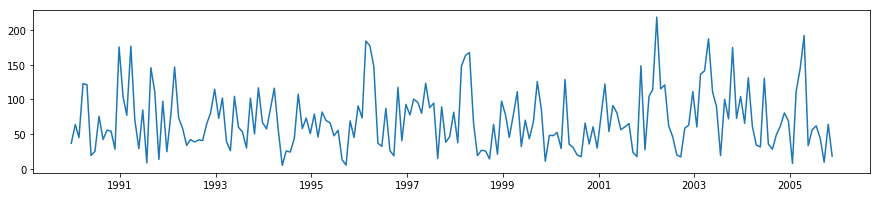

In [157]:
#Plot the values in the dataframe
fig = plt.figure(figsize=(15,3))
plt.plot(df_timeseries);

### 4.2.2 Selecting a *slice* of time
With our data in Pandas dataframe and the actual times set as the index, we can select, subset, or **slice** our data on actual times. We can do this by creating Boolean <u>masks</u> fitting our time constraints. Below we'll make two masks, one for all records after 1995 and one for all records before 2003. Then we'll combine these 

In [181]:
#Subset the data
df_subset = df_timeseries[(df_timeseries.index > '1998') & 
                          (df_timeseries.index < '2004')]

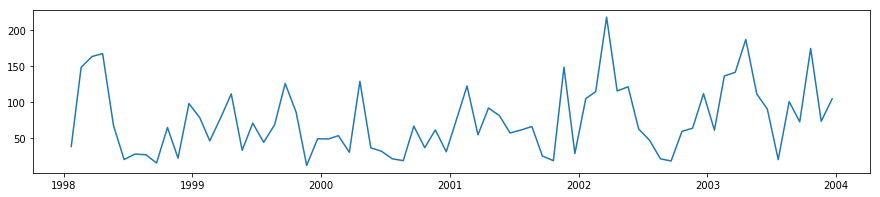

In [182]:
#Plot the subset
fig = plt.figure(figsize=(15,3))
plt.plot(df_subset);

#### 4.2.2 Creating a map for one time slice
What if we fix time and then plot data across space? Well create a 2d array for one time snapshot and then map it.

In [ ]:
arr

In [ ]:
lonMask = 235 < arrLon & arrLon < 240
latMask = 25 < arrLat #and arrLat < 30
timeMask = np.datetime64('1999-01-01') < arrTime #and (arrTime < np.datetime64('1999-05-01'))

In [ ]:
timeAvg = precip[timeMask,:,:].mean(axis=0)

In [ ]:
plt.scatter(arrLon, arrLat, c=timeAvg, s=15, edgecolors='none')
plt.colorbar()
plt.scatter(x+1, y, c=z_masked, s=15, edgecolors='none')
plt.colorbar()
plt.show()

In [ ]:
df = pd.DataFrame(arrPrecip.sum(axis=0)).T
df.columns=arrLat.tolist()
df['LON']=arrLon.tolist()
df.head()

In [ ]:
dfX = pd.melt(df,id_vars='LON',var_name='LAT',value_name='Precip')

In [ ]:
dfX.dtypes

In [ ]:
#Return the dimension size of the variable precip
[ntime,nlat,nlon] = dataset.variables['precipitation'].shape
print(ntime," time values")
print(nlat," latitude values")
print(nlon," longitude values")

In [ ]:
#Show the dimensions of the other variables
print("Time: ",time.shape)
print("Latitude: ",lat.shape)
print("Longitude: ",lon.shape)

## Pandas

In [ ]:
import pandas as pd

In [ ]:
df = pd.Panel(precip[:],major_axis=arrLat,minor_axis=arrLon).to_frame() 

In [ ]:
df.head()

In [ ]:
l[0],l[1]

In [ ]:
latVals = lat[:].tolist()
lonVals = lon[:].tolist()

In [ ]:
df.index = df.index.set_levels((latVals,lonVals))
df

In [ ]:
df2 = df.reset_index()
df2.rename()

# X-Array
http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html
https://scottwales.github.io/swc-climatedata/02-xarray/

In [ ]:
import xarray as xr

In [ ]:
xdf = xr.DataArray(precip[:])

In [ ]:
xnc = xr.open_dataset(fileName)

In [ ]:
xp = xnc.variables['precipitation']
xp.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ds.

In [ ]:
xnc.coords['lat']

# Plotting
With our data as numpy arrays we can now plot, using the Python `matplotlib` package.

Info on colors, etc can be found here:<br>https://matplotlib.org/examples/color/colormaps_reference.html

In [ ]:
#Import the plotting components
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
#Plot a map for a selected time slice
plt.figure(figsize=(20,8))
plt.imshow(timeAvg,origin=(0,0),cmap="YlGnBu")
plt.colorbar();

In [ ]:
#Plot a map for a selected geographic slice
minLat = 36; maxLat = 56
minLon = 220; maxLon = 260
latMask = (arrLat > minLat) & (arrLat < maxLat)
lonMask = (arrLon > minLon) & (arrLon < maxLon)

In [ ]:
dfGeog = precip[:,latMask,lonMask].mean(axis=0)
dfGeog.shape

In [ ]:
xTcs = arrLon[lonMask].data
yTcs = arrLat[latMask].data


In [ ]:
plt.figure(figsize=(20,8))
plt.imshow(dfGeog,origin=(0,0),cmap="YlGnBu")
plt.xticks(np.arange(xTcs.size,step=25),xTcs)
plt.yticks(np.arange(yTcs.size,step=25),yTcs)
plt.colorbar();

Now, let's move on to making our own masks. Here

In [ ]:
#Display the bounds of each axis
print("Lat:",arrLat.min(),arrLat.max())
print("Lon:",arrLon.min(),arrLon.max())
print("Time:",arrTime.min(),arrTime.max())

In [ ]:
#Meshgrid
mlon,mlat = np.meshgrid(arrLon,arrLat)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.contourf(mlon,mlat,precip[1,:,:],linestyles='none')
plt.colorbar();
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,1,2)
plt.contourf(mlon,mlat,precip[1,:,:],linestyles='none')
plt.colorbar();
plt.xlabel('Longitude')
plt.ylabel('Latitude');


In [ ]:
arrLat.shape,arrLon.shape,precip.shape

In [ ]:
#Lat/lon slices
latMask = (arrLat>30) & (arrLat<31)
lonMask = (arrLon>230) & (arrLon<231)

In [ ]:
#Lat/lon slices
latMask = (mlat>30) & (mlat<31)
lonMask = (mlon>230) & (mlon<231)
latMask.shape,lonMask.shape

In [ ]:
arrPrecip

# Calculate summer (JJA) average
Reduce the 3 dimensional precip data to two dimension by averaging over time

In [ ]:
avgPrecip = arrPrecip.mean(axis=0)

In [ ]:
tSlice = arrPrecip[arrTime >= np.datetime64('1999'),:,:]
tSlice.shape

In [ ]:
nyear = int(ntime/12)
year = np.arange(1995,2006)
precip_JJA = np.zeros((nyear,nlon,nlat))

In [ ]:
arrTime.astype(np.datetime64[Y])

In [ ]:
year = 1997
yearMask = arrPrecip[arrTime == np.datetime64(str(year)),:,:]
yearMask.shape

In [ ]:
for ii in year:
    #Create the mask
    precip_JJA(ii,:,:) = arrPrecip

In [ ]:
foo = np.broadcast_to(1,arrLat)

In [ ]:
#Lat/lon slices
latMask = (arrLat>30) & (arrLat<31)
lonMask = (arrLon>230) & (arrLon<231)
latMask.shape,lonMask.shape

In [ ]:
foo = np.ma.masked_where(latMask>30,arrPrecip)
foo.shape

In [ ]:
bigMask = np.ma.mask_or(latMask,lonMask,arrPrecip.mask)

In [ ]:
foo = np.broadcast_to(bigMask,arrPrecip.shape)

In [ ]:
#Plot a map for a selected time slice
plt.figure(figsize=(20,8))
plt.imshow(foo[0,:,:],origin=(0,0),cmap="YlGnBu")
plt.colorbar();

In [ ]:
latMask = (latMesh>30) & (latMesh<34)
lonMask = (lonMesh>230) & (lonMesh<235)

In [ ]:
#https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
precipX = arrPrecip[0,latMask,lonMask]

In [ ]:
arrTime.astype('datetime64[M]')

In [ ]:
arrTime[arrTime<np.datetime64(1995)]

In [ ]:
time2 == np.datetime64('1995')

In [ ]:
pPanel = pd.Panel(rollaxis(a,0)).to_frame()

In [ ]:
#Create mesh grids 
xx,yy = np.meshgrid(lon[:],lat[:])

In [ ]:
xx.shape, yy.shape

In [ ]:
xMask= 

---
---
---

In [ ]:
# return the attribute of the variable precip
units = precip.units
print(units)

---
Because Python has much broader uses than MatLab, we need to use a specific package to handle data arrays. This package is called `NumPy`

In [ ]:
# Import the numpy package
import numpy as np

In [ ]:
# convert variables to NumPy arrays
arrLon = lon[:]
arrLat = lat[:]
arrTime = time[:]
arrPrecip = precip[:]

The `[:]` extracts the values in each netCDF variable into a "masked array". A *masked* array only different from a standard array in that it includes a corresponding Boolean array that indicates which cells have values. 

In [ ]:
# Show the data type of the arrPrecip
type(arrPrecip)

In [ ]:
#Show the shape of the array
arrPrecip.mask.shape

In [ ]:
arrPrecip.size, arrPrecip.mask.size

...back to our MatLab analog, but now working with the arrPrecip numpy array in place of the NetCDF variable

In [ ]:
# replace fillvalues with nan(not a number)
##-->We don't have to do this as the arrays are masked already!##
print("Min of masked data = ",arrPrecip[arrPrecip.mask == False].min())
print("Min of all data =",arrPrecip.data.min())

In [ ]:
# calculate summer(JJA) average
nyear = int(ntime / 12)
year = np.arange(1990,2006)
precip_JJA = np.zeros((nlon,nlat,nyear))
for ii in year:
    startTime = 6+12*(ii-1)
    endTime = 8+12*(ii-1)
    #precip_JJA(ii,:,:) = precip()
    arrPrecip(6+12*(ii-1):8+12*(ii-1)),:,:)

In [ ]:
year = 1995
startTime = 6+12*(year-1)
endTime = 8+12*(year-1)
arrPrecip[startTime:endTime,:,:].mean()

In [ ]:
arrPrecip.shape

In [ ]:
arrPrecip[:,250,500].data
